In [2]:

# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers, models

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
data_dir = r'C:\Users\muham\Downloads\HAM10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [87]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Assuming Data is your images and Label are your corresponding labels
# Reshape Data from (46935, 28, 28, 3) to (46935, 28 * 28 * 3)
Data_flattened = Data.reshape(Data.shape[0], -1)  # Reshape to (46935, 2352)

oversample = RandomOverSampler()
Data_resampled, Label_resampled = oversample.fit_resample(Data_flattened, Label)

# If you need to reshape back to original dimensions after oversampling
Data_resampled = Data_resampled.reshape(-1, 28, 28, 3)
Data = Data_resampled
Label = Label_resampled
# Check the shape after oversampling
print('Shape of Data after oversampling:', Data_resampled.shape)
print('Shape of Labels after oversampling:', Label_resampled.shape)


Shape of Data after oversampling: (46935, 28, 28, 3)
Shape of Labels after oversampling: (46935,)


In [88]:
Label = np.array(Label)

In [91]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(Data, Label, test_size=0.25, random_state=49)

In [97]:
print(f'X train shape{X_train.shape}')
print(f'y train shape{y_train.shape}')
print(f'X test shape{X_test.shape}')
print(f'y test shape{y_test.shape}')


X train shape(35201, 28, 28, 3)
y train shape(35201,)
X test shape(11734, 28, 28, 3)
y test shape(11734,)


In [99]:
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [101]:
y_train.shape

(35201, 7)

In [103]:
datagen = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
testgen = ImageDataGenerator(rescale=(1./255))

In [105]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # The metric to monitor
    patience=2,              # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,               # Verbosity mode; 1 = print messages when the learning rate is reduced
    factor=0.5,              # Factor by which the learning rate will be reduced; new_lr = lr * factor
    min_lr=0.00001           # Lower bound on the learning rate
)


In [107]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adamax

# Initialize the model
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())

# Fourth Convolutional Block
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())

# Flatten and Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.L1L2()))
model.add(layers.BatchNormalization())

# Output Layer
model.add(layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Compile the Model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the Model Summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,275,079 (4.86 MB)

 Trainable params: 1,273,671 (4.86 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [109]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 137s 451ms/step - accuracy: 0.4297 - loss: 1.5402 - val_accuracy: 0.6903 - val_loss: 0.8974 - learning_rate: 0.0010
Epoch 2/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 124s 450ms/step - accuracy: 0.7997 - loss: 0.6095 - val_accuracy: 0.8713 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 3/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 144s 456ms/step - accuracy: 0.8920 - loss: 0.3228 - val_accuracy: 0.9044 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 4/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 128s 462ms/step - accuracy: 0.9214 - loss: 0.2241 - val_accuracy: 0.9189 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 5/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 122s 441ms/step - accuracy: 0.9480 - loss: 0.1545 - val_accuracy: 0.9420 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 6/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 122s 442ms/step - accuracy: 0.9591 - loss: 0.1201 - val_accuracy: 0.9412 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 7/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 123s 444ms/step - accura

In [117]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

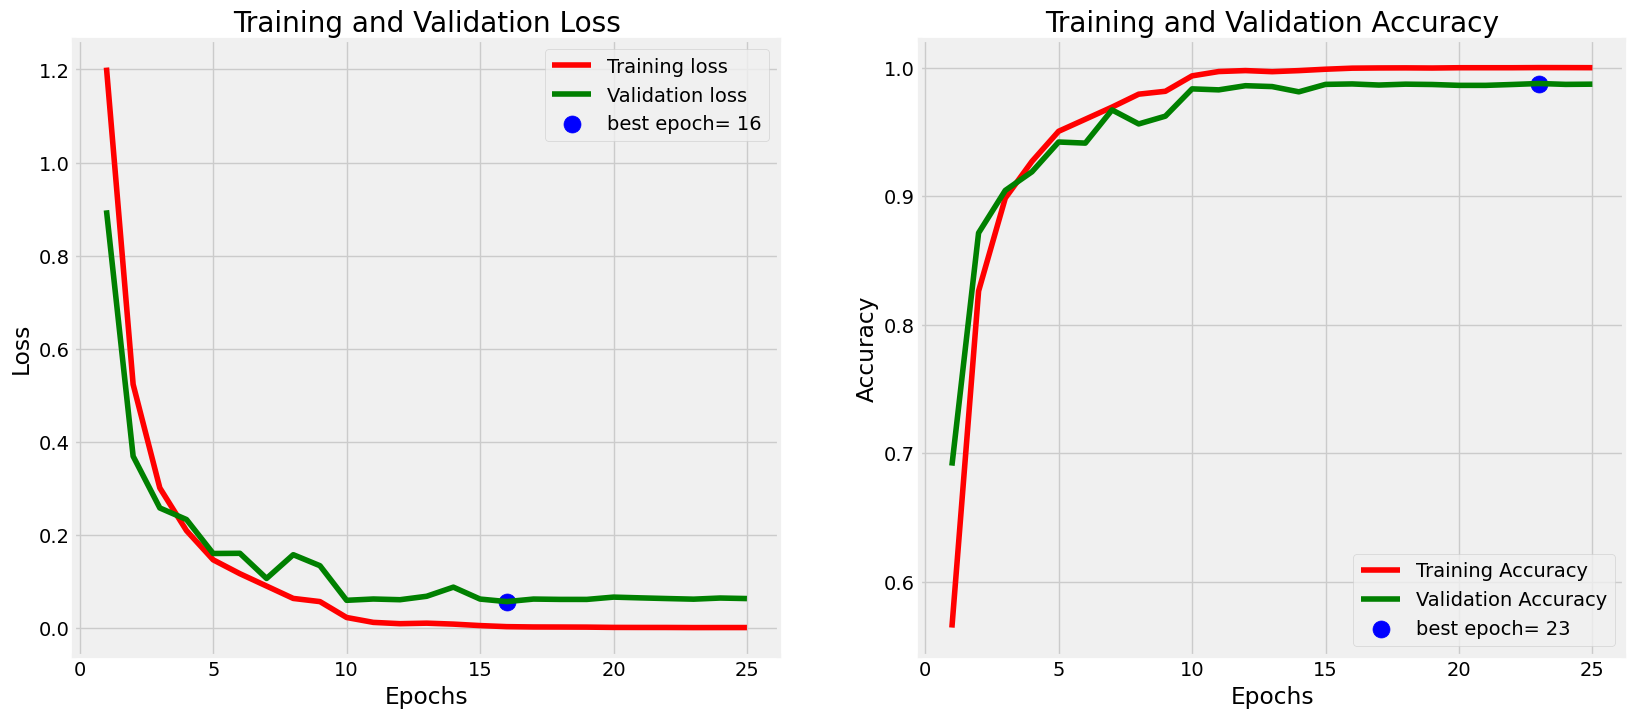

In [119]:
plot_training(history)

In [121]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 1.0000 - loss: 1.8347e-04
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9859 - loss: 0.0706
Train Loss:  0.00018211379938293248
Train Accuracy:  1.0
--------------------
Test Loss:  0.06335661560297012
Test Accuracy:  0.9870461821556091


In [123]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


In [125]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [129]:
model.save('Skin Disease.h5')

In [21]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Step 1: Load your trained model
model = load_model(r'C:\Users\muham\Documents\Skin Disease Model\v3p2.h5')  # Replace with your model's path

# Step 2: Load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = Image.open(image_path)
    
    # Resize the image to 28x28 (or whatever your model expects)
    img = img.resize((56, 56))
    
    # Convert to RGB if the image is grayscale
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Normalize the pixel values (if your model was trained on normalized data)
    img_array = img_array / 255.0
    
    # Reshape the image for the model (add batch dimension)
    img_array = img_array.reshape(1, 56, 56, 3)  # Shape should be (1, 28, 28, 3)
    
    return img_array

# Replace 'path_to_your_image.png' with the path to your image
image_path = 'sample.jpg'
preprocessed_image = load_and_preprocess_image(image_path)

# Step 3: Make prediction
predictions = model.predict(preprocessed_image)

# Step 4: Interpret the result
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class[0]}')  # Output the predicted class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted class: 2


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from PIL import Image

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 3)),
    MaxPooling2D((2, 2)),
    # Add other layers as per your original model
    Flatten(),
    Dense(10, activation='softmax')  # Adjust the output layer as per your classes
])

# Load the weights
model.load_weights(r'C:\Users\muham\Documents\Skin Disease Model\Skin_Cancerv3p2_weights.h5')  # Path to weights file

# Proceed with prediction as before


ValueError: Layer count mismatch when loading weights from file. Model expected 2 layers, found 0 saved layers.